In [1]:
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras import models
from keras import layers
from keras import regularizers



In [2]:
NM_WORDS = 10000
NB_START_EPOCHS = 20
BATCH_SIZE = 512
MAX_LEN = 20

In [3]:
root = Path('../')
input_path = root / 'input/'
output_path = root / 'output/'
source_path = root / 'source/'


In [80]:
def deep_model(model,X_train,y_train,X_valid,y_valid):
  model.compile(optimizer='adam',
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])
  history = model.fit(X_train,
                      y_train,epochs=NB_START_EPOCHS,batch_size=BATCH_SIZE,validation_data=(X_valid,y_valid)
                      ,verbose=0)
  return history

def eval_metric(model,history,metric_name):
  metric = history.history[metric_name]
  val_metric = history.history['val_' + metric_name]

  e = range(1,NB_START_EPOCHS + 1)

  plt.plot(e,metric,'bo',label='Train' + metric_name)
  plt.plot(e,val_metric,'b',label='Validation' + metric_name)
  plt.xlabel('Epoch Number')
  plt.ylabel(metric_name)
  plt.title('Comparing training and validation' + metric_name + 'for' + model.name)
  plt.legend()
  plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
  model.fit(X_train
            , y_train
            , epochs=epoch_stop
            , batch_size=BATCH_SIZE
            , verbose = 0)
  results = model.evaluate(X_test,y_test)
  print()
  print(' Test accuracy: {0:.2f}%'.format(results[1]*100))
  return results


def remove_stopwords(input_text):
  stopwords_list = stopwords.words('english')
  whitelist = ["n t","not","no"]
  words = input_text.split()
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
  return " " . join(clean_words)


def remove_mentions(input_text):
  return re.sub(r'@/w+','',input_text)

def compare_model_by_metric(model_1,model_2,model_hist_1,model_hist_2,metric):
  metric_model_1 = model_hist_1.history[metric]
  metric_model_2 = model_hist_2.history[metric]

  e = range(1,NB_START_EPOCHS + 1)

  metrics_dict = {
      'acc' : 'Training Accuracy',
      'loss' : 'Training Loss',
      'val_ac' : 'Validation Accuracy',
      'val_loss' : 'Validation Loss',
  }

  metric_label = metrics_dict[metric]

  plt.plot(e,metric_model_1,'bo',label=model_1.name)
  plt.plot(e,metric_model_2,'b',label=model_2.name)
  plt.xLabel('Epoch Number')
  plt.yLabel(metric_label)
  plt.title('Comparing ' + metric_label  + 'between models')
  plt.legend()
  plt.show()

def optimal_epoch(model_hist):
  min_epoch = np.argmin(model_hist.history['val_loss'])+1
  print("Minimum validation loss reached in epoch{}".format(min_epoch))
  return min_epoch



In [47]:
import nltk
import pandas as pd
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
df = pd.read_csv('Tweets.csv')
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)


In [49]:
X_train,X_test,y_train,y_test = train_test_split(df.text,df.airline_sentiment,test_size=0.1,random_state=37)
print(' # Train Data Samples : ' , X_train.shape[0])
print(' # Test Data Samples : ' , X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

 # Train Data Samples :  13176
 # Test Data Samples :  1464


In [50]:
tk = Tokenizer(num_words=NM_WORDS,
               filters='!"#$&()*+,-./:;<=>?@[//]^_`{|}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))



Fitted tokenizer on 13176 documents
10000 words in dictionary


In [51]:
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')


In [52]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{} is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{} is converted into {}'.format(y_train_le[0], y_train_oh[0]))



"neutral is converted into 0
"0 is converted into [1. 0. 0.]


In [53]:
X_train_rest, X_valid , y_train_rest, y_valid = train_test_split(X_train_oh,y_train_oh, test_size=0.1,random_state=37)
assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('shape of validation set:',X_valid.shape)

shape of validation set: (1318, 10000)


In [54]:
import tensorflow
from tensorflow.keras import layers,models



In [55]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation = 'relu', input_shape=(NM_WORDS,)))
base_model.add(layers.Dense(64, activation = 'relu'))
base_model.add(layers.Dense(3, activation = 'softmax'))
base_model.model_name = 'Baseline model'
base_model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                640064    
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644419 (2.46 MB)
Trainable params: 644419 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
base_history = deep_model(base_model, X_train_rest,y_train_rest,X_valid,y_valid)
base_min = optimal_epoch(base_history)

Minimum validation loss reached in epoch4


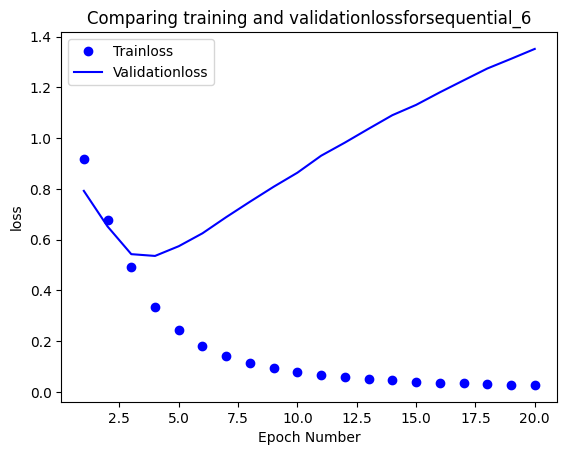

In [59]:
eval_metric(base_model,base_history,'loss')

In [70]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001),activation='relu',input_shape=(NM_WORDS,)))
reg_model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001),activation='relu'))
reg_model.add(layers.Dense(3,activation='softmax'))
reg_model.model_name = 'L1 & L2 Regularization model'
reg_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 64)                640064    
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644419 (2.46 MB)
Trainable params: 644419 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64,activation='relu',input_shape=(NM_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64,activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3,activation='softmax'))
drop_model.model_name = 'Droput Layers Model'
drop_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644419 (2.46 MB)
Trainable params: 644419 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
drop_history = deep_model(drop_model, X_train_rest,y_train_rest,X_valid,y_valid)
drop_min = optimal_epoch(drop_history)



Minimum validation loss reached in epoch1


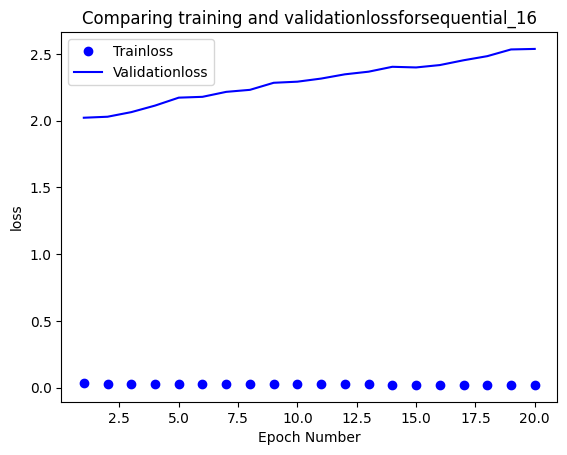

In [81]:
eval_metric(drop_model,drop_history,'loss')

In [82]:
base_results = test_model(base_model,X_train_oh,y_train_oh,X_test_oh,y_test_oh,base_min)

46/46 [==============================] - 0s 4ms/step - loss: 1.4123 - accuracy: 0.7575

 Test accuracy: 75.75%


In [84]:
drop_results = test_model(drop_model,X_train_oh,y_train_oh,X_test_oh,y_test_oh,base_min)

46/46 [==============================] - 0s 3ms/step - loss: 1.3095 - accuracy: 0.7725

 Test accuracy: 77.25%


In [ ]:
base_results = test_model(base_model,X_train_oh,y_train_oh,X_test_oh,y_test_oh,base_min)